# Gather Starling Data
#### Date: 8/30/2022, JX
> Gather local starling data from https://doi.org/10.5281/zenodo.3237218 and get amplitude envelopes


In [1]:
from starling_rhythm.utils.paths import DATA_DIR

## Get list of wavs

In [2]:
from pathlib import Path
from glob import glob

In [3]:
DATA_DIR = Path('/mnt/sphere/speech_bci/derived_data/s_b1555_22/')

In [4]:
wav_paths = list(Path(DATA_DIR).rglob("2022-09-2*/alsa/bouts_ceciestunepipe/bout_checked.pickle"))

In [5]:
wav_paths

[PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-23/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-29/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-24/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-20/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-27/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-25/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-28/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-09-22/alsa/bouts_ceciestunepipe/bout_checked.pickle'),
 PosixPath('/mnt/sphere/speech_bci/derived_data/

## Extract Amplitude Envelope

In [6]:
import pandas as pd

In [7]:
## modified

from scipy.io.wavfile import read
from scipy.signal import hilbert, get_window
from librosa import resample
import noisereduce as nr
import pandas as pd
import numpy as np

def int16_to_float32(data):
    """ Converts from uint16 wav to float32 wav
    """
    if np.max(np.abs(data)) > 32768:
        raise ValueError("Data has values above 32768")
    return (data / 32768.0).astype("float32")


def extract_amp_env(
    data, 
    target_sr, 
    win_type = 'boxcar', 
    res_type = 'linear',
    stds = 1,
    buffer = 100
):
    '''
    Extract amplitude envelope of recordings. Attach ID info to the envelope. 
    ## Input: wav_path
    ## Output: df_entry
    '''
    
    sr = 48000
    data = int16_to_float32(data)
    data = nr.reduce_noise(y=data, sr=sr)
    
    ## Transform waveform into an analytic signal (has no negative frequency), 
    analytic_sig = hilbert(data)
    
    ## The absolute value of an analytic signal is a representative amplitude envelope
    amp_env = np.abs(analytic_sig)
    
    ## Rolling window average (boxcar window) 10 ms window
    amp_env = np.convolve(amp_env, get_window(win_type, int((sr*10)/1000)))
    
    ## resample the amp env to have 1 ms step
    amp_env = resample(amp_env, orig_sr = sr, target_sr = target_sr, res_type = res_type)
    
    ## make compact support time series
    #amp_env = compact_support(amp_env, stds = stds, buffer = buffer)
    
    return amp_env

def compact_support(amp_env, stds = 1, buffer = 500):
    '''
    Takes amplitude envelope and create compact support
    '''
    
    ## take standard deviation of the time-series
    amp_env_sd = np.std(amp_env)
    
    ## amplitude envelopes should start some number of standard deviations away from 0
    ae_indices = np.argwhere(amp_env > stds * amp_env_sd)
    strt = ae_indices[0][0] - buffer ## start and ends should have some buffers
    end = ae_indices[-1][0] + buffer
    
    ## check if strt and end are legal
    if strt < 0:
        strt = 0
    if end > (len(amp_env) - 1):
        end = (len(amp_env) - 1)
    
    return amp_env[strt:end]

def time_windows(amp_env, num = 50):
    '''
    Takes amplitude envelope and create log-scaled time windows from 1ms to full length of the song
    '''
    
    lag = np.unique(np.geomspace(1, len(amp_env), num = num).astype(int))
    
    return lag

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import numpy as np
import pandas as pd

In [9]:
n_jobs = 36 ## joblib setting
verbose = 0

In [10]:
## for each pickle address

bouts_df = []

for wav_path in wav_paths:
    ## get dataframe
    bouts = pd.read_pickle(wav_path)
    ## delete calls
    bouts = bouts[bouts['is_call'] != True]
    
    ## for the pickle, extract its amp env
    with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
        amp_envs = parallel(
            delayed(extract_amp_env)(
                wav_path,
                target_sr = 200, ## each number is 5 ms
                win_type = 'boxcar', ## smooth with boxcar window (rolling average)
                res_type = 'linear', ## linear resample
                stds = 1, ## make compact support
                buffer = 100 ## buffer compact support
            )
            for wav_path in tqdm(bouts['waveform'], desc = 'Extracting Amplitude Envelope')
        )
    
    bouts['amp_env'] = amp_envs
    
    bouts_df.append(bouts)
    
bouts_df = pd.concat(bouts_df)

Extracting Amplitude Envelope:  53%|█████▎    | 72/135 [00:04<00:04, 15.36it/s] /home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Extracting Amplitude Envelope: 100%|██████████| 100/100 [00:04<00:00, 22.13it/s]
/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Extracting Amplitude Envelope: 100%|██████████| 88/88 [00:06<00:00, 14.15it/s]
/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the execu

## Proof

In [11]:
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

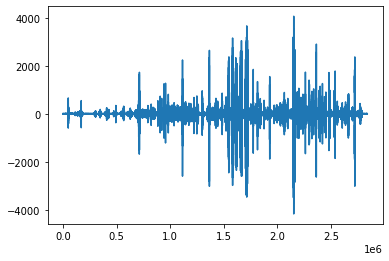

In [12]:
plt.plot(bouts['waveform'].values[0])

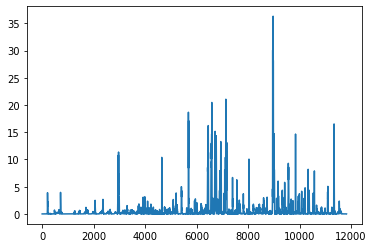

In [13]:
plt.plot(bouts['amp_env'].values[0])

## Pickle dataframe

In [14]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir

In [15]:
SAVE_PATH = PROCESSED_DIR / 'starling_b1555_amp_envs200.pickle'
ensure_dir(SAVE_PATH)

In [16]:
bouts_df.to_pickle(SAVE_PATH)